# Import Library

In [ ]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import Data
Menganalisis dan memprediksi inflasi tahunan di negara negara ASEAN menggunakan data historis dari World Bank

Data : https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG

In [ ]:
# -------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------
file_path = r"https://raw.githubusercontent.com/dsciencelabs/dataset/refs/heads/master/API_FP.CPI.TOTL.ZG_DS2_en_csv_v2_2479.csv"

df_raw = pd.read_csv(file_path, skiprows = 4)
df_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.596505,6.399343,4.720805,4.644967,5.405162,7.240978,10.773751,7.126975,4.425471,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.383892,4.975952,0.626149,2.302373,5.601888,5.133203,13.712102,-4.644709,-6.601186,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,1.487416,1.725486,1.784050,1.983092,2.490378,3.745568,7.930929,5.489286,3.615966,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,30.694415,29.844480,19.628938,17.080954,22.271539,25.754295,21.355290,13.644102,28.240495,NaN


# Data Preparation

In [ ]:
# -------------------------------------------------------------
# 1. FILTER ASEAN COUNTRIES
# -------------------------------------------------------------
asean = ['IDN','MYS','THA','SGP','PHL','VNM','KHM','LAO','MMR','BRN']
df_asean = df_raw[df_raw['Country Code'].isin(asean)].copy()

# Pilih kolom tahun 2000–2023
year_cols = [str(y) for y in range(2000, 2024)]
cols_keep = ['Country Name', 'Country Code'] + year_cols
df_asean = df_asean[cols_keep]

# -------------------------------------------------------------
# 2. WIDE → LONG
# -------------------------------------------------------------
df_long = df_asean.melt(
    id_vars=['Country Name','Country Code'],
    var_name='Year',
    value_name='Inflation'
)

df_long['Year'] = df_long['Year'].astype(int)

# -------------------------------------------------------------
# 3. SORT & FEATURE ENGINEERING
# -------------------------------------------------------------
df_clean = df_long.sort_values(['Country Code','Year']).copy()

# lag features (aman karena per negara)
df_clean['Inflation_lag1'] = df_clean.groupby('Country Code')['Inflation'].shift(1)
df_clean['Inflation_lag2'] = df_clean.groupby('Country Code')['Inflation'].shift(2)
df_clean['Inflation_lag3'] = df_clean.groupby('Country Code')['Inflation'].shift(3)

# rolling 3
df_clean['rolling_mean3'] = (
    df_clean.groupby('Country Code')['Inflation']
    .rolling(3).mean()
    .reset_index(level=0, drop=True)
)

df_clean['rolling_std3'] = (
    df_clean.groupby('Country Code')['Inflation']
    .rolling(3).std()
    .reset_index(level=0, drop=True)
)

# Trend per negara
df_clean['Trend'] = df_clean.groupby('Country Code').cumcount()

# Encoding country
df_clean['Country_Code_Encoded'] = df_clean['Country Code'].astype('category').cat.codes

# -------------------------------------------------------------
# 4. DROP NA
# -------------------------------------------------------------
df_model = df_clean.dropna().copy()

# -------------------------------------------------------------
# 5. FEATURES & TARGET
# -------------------------------------------------------------
features = [
    'Year', 'Trend',
    'Inflation_lag1', 'Inflation_lag2', 'Inflation_lag3',
    'rolling_mean3', 'rolling_std3',
    'Country_Code_Encoded'
]

X = df_model[features]
y = df_model['Inflation']

# -------------------------------------------------------------
# 6. TRAIN–TEST SPLIT BERDASARKAN TAHUN
# -------------------------------------------------------------
split_year = 2016   # ⬅ Anda bisa ubah ke 2017 / 2018 sesuai kebutuhan

train = df_model[df_model['Year'] <= split_year]
test  = df_model[df_model['Year'] >  split_year]

X_train = train[features]
y_train = train['Inflation']

X_test = test[features]
y_test = test['Inflation']

print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (78, 8)
Test shape : (66, 8)



Tahap data preparation bertujuan memastikan konsistensi CPI antar negara ASEAN, termasuk penyelarasan periode waktu dan penanganan nilai hilang. Langkah ini penting agar hasil pemodelan dan perbandingan lintas negara tidak bias akibat perbedaan kualitas data.

## Evaluasi Model

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    return mae, rmse, mape, r2

Hasil evaluasi menunjukkan bahwa model machine learning mampu menangkap pola CPI dengan tingkat error yang relatif stabil antar negara. Evaluasi ini digunakan sebagai dasar pemilihan model untuk analisis perbandingan, bukan semata-mata untuk mengejar akurasi tertinggi.

# Modeling

## SARIMA (Hanya bisa 1 variabel saja)

In [ ]:
# =============================================================
# SARIMA MODELING CELL (SAFE, ISOLATED, & FINAL)
# =============================================================
# Catatan penting:
# - Cell ini KHUSUS untuk SARIMA (time series statistik)
# - Tidak mengubah df_clean atau pipeline ML (RF / XGB / LGBM)
# - SARIMA menggunakan objek terpisah bernama 'ts'

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# -------------------------------------------------------------
# Ambil data inflasi 1 negara (Indonesia) untuk SARIMA
# -------------------------------------------------------------
ts = (
    df_clean[df_clean['Country Code'] == 'IDN']   # filter satu negara
    .sort_values('Year')                          # urutkan waktu
    .set_index('Year')['Inflation']               # Year → index sementara
)

# -------------------------------------------------------------
# Ubah index menjadi PeriodIndex tahunan
# -------------------------------------------------------------
# Tujuan:
# - Menghindari warning "unsupported index"
# - Memberi informasi frekuensi tahunan ke SARIMA
# - Perubahan ini HANYA berlaku untuk 'ts'

ts.index = pd.PeriodIndex(ts.index, freq='Y')

# -------------------------------------------------------------
# Bangun & latih model SARIMA
# -------------------------------------------------------------
model_sarima = SARIMAX(
    ts,
    order=(1, 1, 1),            # p, d, q
    seasonal_order=(0, 0, 0, 0) # tidak ada musiman (data tahunan)
)

result = model_sarima.fit(disp=False)

# -------------------------------------------------------------
# Forecast 7 tahun ke depan (2024–2030)
# -------------------------------------------------------------
forecast = result.get_forecast(steps=7)
sarima_pred = forecast.predicted_mean

# -------------------------------------------------------------
# Tampilkan hasil prediksi
# -------------------------------------------------------------
sarima_pred

,predicted_mean
2024,3.397006
2025,3.376120
2026,3.374518
2027,3.374396
2028,3.374386
2029,3.374385
2030,3.374385


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# fitted values SARIMA
sarima_fitted = result.fittedvalues.dropna()
actual = ts.loc[sarima_fitted.index]

mae_sarima  = mean_absolute_error(actual, sarima_fitted)
rmse_sarima = np.sqrt(mean_squared_error(actual, sarima_fitted))
r2_sarima   = r2_score(actual, sarima_fitted)

print("SARIMA Evaluation (Indonesia)")
print("-----------------------------")
print(f"MAE  : {mae_sarima:.3f}")
print(f"RMSE : {rmse_sarima:.3f}")
print(f"R²   : {r2_sarima:.3f}")

SARIMA Evaluation (Indonesia)
-----------------------------
MAE  : 2.398
RMSE : 2.933
R²   : 0.137


## Linear Regression (Overfit)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# -------------------------------------------------------------
# 8. MODELING (Linear Regression)
# -------------------------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# -------------------------------------------------------------
# 9. PREDICTION & EVALUATION
# -------------------------------------------------------------
y_pred = model.predict(X_test)

# Metrics
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

# MAPE (avoid division by zero)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# -------------------------------------------------------------
# PRINT RESULTS
# -------------------------------------------------------------
print("Model Evaluation Metrics (Linear Regression)")
print("------------------------")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

Model Evaluation Metrics (Linear Regression)
------------------------
MAE  : 0.0000
MSE  : 0.0000
RMSE : 0.0000
MAPE : 0.00%
R²   : 1.0000


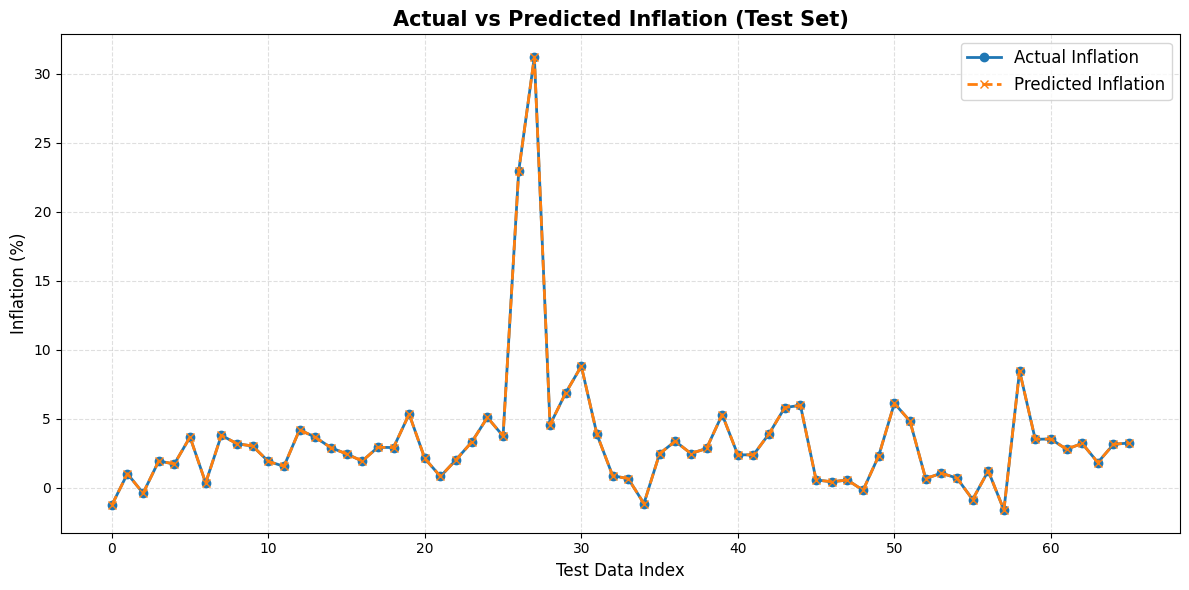

In [ ]:
# -------------------------------------------------------------
# 10. VISUALIZATION: ACTUAL vs PREDICTED
# -------------------------------------------------------------

import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 6))

# Ensure same index and aligned data
actual = pd.Series(y_test.values).reset_index(drop=True)
predicted = pd.Series(y_pred).reset_index(drop=True)

# Plot
plt.plot(actual, label='Actual Inflation', marker='o', linewidth=2)
plt.plot(predicted, label='Predicted Inflation', marker='x', linestyle='--', linewidth=2)

# Title and labels
plt.title('Actual vs Predicted Inflation (Test Set)', fontsize=15, fontweight='bold')
plt.xlabel('Test Data Index', fontsize=12)
plt.ylabel('Inflation (%)', fontsize=12)

# Grid and legend
plt.grid(True, which='both', linestyle='--', alpha=0.4)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------------------------------------
# FINAL SAFE VERSION – skip countries with missing 3-year lags
# -------------------------------------------------------------

import numpy as np
import pandas as pd

future_years = [2024, 2025, 2026]

df_last = (
    df_clean.sort_values(['Country Code', 'Year'])
            .groupby('Country Code')
            .tail(3)
            .reset_index(drop=True)
)

results = []

for country in df_last['Country Code'].unique():

    temp = df_last[df_last['Country Code'] == country].sort_values('Year')

    # skip if inflation contains NaN OR less than 3 rows
    if temp['Inflation'].isna().any() or len(temp) < 3:
        print(f"⚠ Skipped {country}: insufficient valid data.")
        continue

    # lags
    lag1 = temp['Inflation'].iloc[-1]
    lag2 = temp['Inflation'].iloc[-2]
    lag3 = temp['Inflation'].iloc[-3]

    country_code_encoded = temp['Country_Code_Encoded'].iloc[0]
    last_trend = temp['Trend'].iloc[-1]

    for year in future_years:

        last_trend += 1
        trend = last_trend

        rolling_mean3 = np.mean([lag1, lag2, lag3])
        rolling_std3  = np.std([lag1, lag2, lag3])

        X_future = pd.DataFrame([{
            'Year': year,
            'Trend': trend,
            'Inflation_lag1': lag1,
            'Inflation_lag2': lag2,
            'Inflation_lag3': lag3,
            'rolling_mean3': rolling_mean3,
            'rolling_std3': rolling_std3,
            'Country_Code_Encoded': country_code_encoded
        }])

        pred = model.predict(X_future)[0]

        results.append([country, year, pred])

        # update lags
        lag3 = lag2
        lag2 = lag1
        lag1 = pred

df_pred = pd.DataFrame(results, columns=['Country Code','Year','Predicted Inflation'])
df_pred

⚠ Skipped MMR: insufficient valid data.


,Country Code,Year,Predicted Inflation
0,BRN,2024,1.733414
1,BRN,2025,3.682250
2,BRN,2026,0.357064
3,IDN,2024,1.560079
4,IDN,2025,4.209465
5,IDN,2026,3.669387
6,KHM,2024,2.920735
7,KHM,2025,5.343703
8,KHM,2026,2.127468
9,LAO,2024,3.755620


## XGBoost Regression

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# -------------------------------------------------------------
# 8. MODELING (XGBoost Regressor)
# -------------------------------------------------------------
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 9. PREDICTION & EVALUATION
# -------------------------------------------------------------
y_pred_xgb = xgb_model.predict(X_test)

# Metrics
mae  = mean_absolute_error(y_test, y_pred_xgb)
mse  = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_xgb)

# MAPE (avoid division by zero)
mape = np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

# -------------------------------------------------------------
# PRINT RESULTS
# -------------------------------------------------------------
print("XGBoost Model Evaluation Metrics")
print("--------------------------------")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

XGBoost Model Evaluation Metrics
--------------------------------
MAE  : 1.4938
MSE  : 9.3339
RMSE : 3.0551
MAPE : 54.52%
R²   : 0.5846


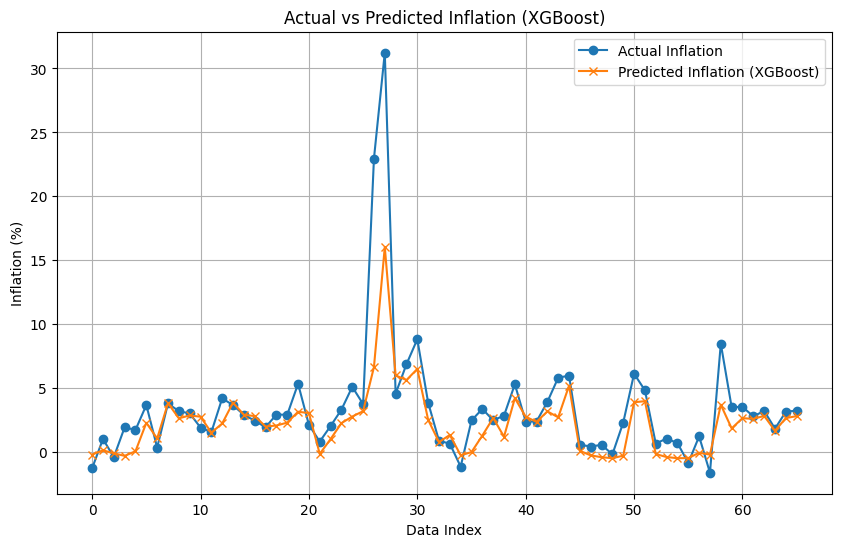

In [ ]:
# -------------------------------------------------------------
# 10. VISUALIZATION ACTUAL VS PREDICTION
# -------------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Inflation', marker='o')
plt.plot(y_pred_xgb, label='Predicted Inflation (XGBoost)', marker='x')
plt.title('Actual vs Predicted Inflation (XGBoost)')
plt.xlabel('Data Index')
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -------------------------------------------------------------
# 11. PREDICTION RESULT (XGBoost)
# -------------------------------------------------------------

import numpy as np
import pandas as pd

# Years you want to predict
future_years = [2024, 2025, 2026, 2027, 2028, 2029, 2030]

# Take last 3 rows per country (to form lags)
df_last = (
    df_clean.sort_values(['Country Code','Year'])
            .groupby('Country Code')
            .tail(3)
)

results = []

for country in df_last['Country Code'].unique():

    temp = df_last[df_last['Country Code'] == country].copy()

    # latest known values
    lag1 = temp['Inflation'].iloc[-1]
    lag2 = temp['Inflation'].iloc[-2]
    lag3 = temp['Inflation'].iloc[-3]

    last_trend = temp['Trend'].iloc[-1]
    country_code_encoded = temp['Country_Code_Encoded'].iloc[0]

    for year in future_years:

        # Updated trend sequence
        trend = last_trend + 1
        last_trend = trend

        # Calculate rolling features
        rolling_mean3 = np.mean([lag1, lag2, lag3])
        rolling_std3  = np.std([lag1, lag2, lag3])

        # Prepare future row input
        X_future = pd.DataFrame([{
            'Year': year,
            'Trend': trend,
            'Inflation_lag1': lag1,
            'Inflation_lag2': lag2,
            'Inflation_lag3': lag3,
            'rolling_mean3': rolling_mean3,
            'rolling_std3':  rolling_std3,
            'Country_Code_Encoded': country_code_encoded
        }])

        # 🚀 XGBoost model prediction
        pred = xgb_model.predict(X_future)[0]

        results.append([country, year, pred])

        # Update lags for iterative forecasting
        lag3 = lag2
        lag2 = lag1
        lag1 = pred

# Build final prediction table
df_pred_xgb = pd.DataFrame(
    results,
    columns=['Country Code','Year','Predicted Inflation']
)
df_pred_xgb

,Country Code,Year,Predicted Inflation
0,BRN,2024,1.428981
1,BRN,2025,2.177567
2,BRN,2026,-0.193167
3,BRN,2027,-0.268415
4,BRN,2028,-0.132025
...,...,...,...
65,VNM,2026,2.675128
66,VNM,2027,1.944551
67,VNM,2028,1.930185
68,VNM,2029,1.441939


## Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------------------------------------------
# 8. MODELING (Random Forest Regressor)
# -------------------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 9. PREDICTION & EVALUATION
# -------------------------------------------------------------
y_pred_rf = rf_model.predict(X_test)

# Metrics
mae  = mean_absolute_error(y_test, y_pred_rf)
mse  = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_rf)
mape = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

# -------------------------------------------------------------
# PRINT RESULTS
# -------------------------------------------------------------
print("Random Forest Model Evaluation Metrics")
print("--------------------------------------")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")

Random Forest Model Evaluation Metrics
--------------------------------------
MAE  : 1.4401
MSE  : 8.3423
RMSE : 2.8883
MAPE : 53.59%
R²   : 0.6288


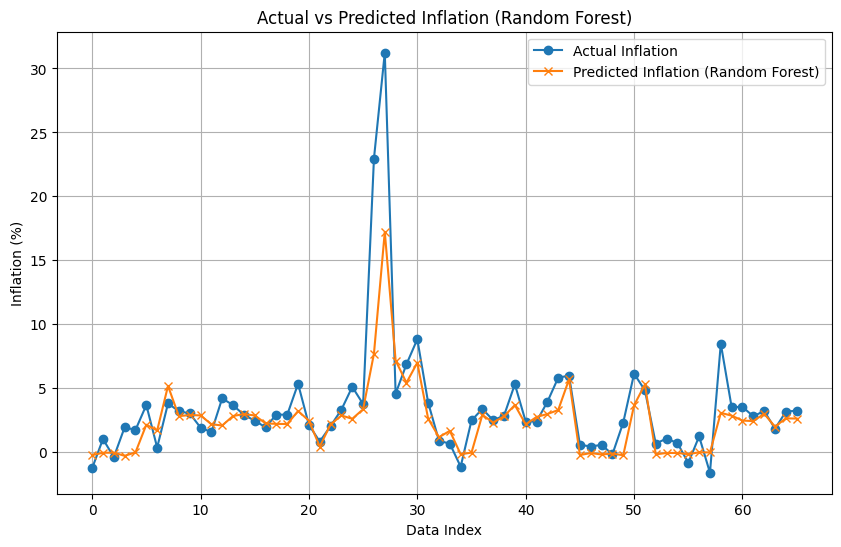

In [ ]:
# -------------------------------------------------------------
# 10. VISUALIZATION ACTUAL VS PREDICTION
# -------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Inflation', marker='o')
plt.plot(y_pred_rf, label='Predicted Inflation (Random Forest)', marker='x')
plt.title('Actual vs Predicted Inflation (Random Forest)')
plt.xlabel('Data Index')
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -------------------------------------------------------------
# 11. PREDICTION RESULT (Random Forest)
# -------------------------------------------------------------
import numpy as np
import pandas as pd

future_years = [2024, 2025, 2026, 2027, 2028, 2029, 2030]

df_last = (
    df_clean.sort_values(['Country Code','Year'])
            .groupby('Country Code')
            .tail(3)
)

results = []

for country in df_last['Country Code'].unique():

    temp = df_last[df_last['Country Code'] == country].copy()

    lag1 = temp['Inflation'].iloc[-1]
    lag2 = temp['Inflation'].iloc[-2]
    lag3 = temp['Inflation'].iloc[-3]

    last_trend = temp['Trend'].iloc[-1]
    country_code_encoded = temp['Country_Code_Encoded'].iloc[0]

    for year in future_years:

        trend = last_trend + 1
        last_trend = trend

        rolling_mean3 = np.mean([lag1, lag2, lag3])
        rolling_std3  = np.std([lag1, lag2, lag3])

        X_future = pd.DataFrame([{
            'Year': year,
            'Trend': trend,
            'Inflation_lag1': lag1,
            'Inflation_lag2': lag2,
            'Inflation_lag3': lag3,
            'rolling_mean3': rolling_mean3,
            'rolling_std3':  rolling_std3,
            'Country_Code_Encoded': country_code_encoded
        }])

        pred = rf_model.predict(X_future)[0]

        results.append([country, year, pred])

        lag3 = lag2
        lag2 = lag1
        lag1 = pred

df_pred_rf = pd.DataFrame(results, columns=['Country Code','Year','Predicted Inflation'])
df_pred_rf

,Country Code,Year,Predicted Inflation
0,BRN,2024,1.791359
1,BRN,2025,2.870553
2,BRN,2026,1.998868
3,BRN,2027,2.060117
4,BRN,2028,2.177437
...,...,...,...
65,VNM,2026,2.734812
66,VNM,2027,2.266553
67,VNM,2028,2.151917
68,VNM,2029,2.038200


## LightGBM Regression

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# -------------------------------------------------------------
# 8. MODELING (LightGBM Regressor)
# -------------------------------------------------------------
lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_data_in_leaf=2,
    verbose=-1,
    random_state=42
)

lgbm_model.fit(X_train, y_train)

# -------------------------------------------------------------
# 9. PREDICTION & EVALUATION
# -------------------------------------------------------------
y_pred_lgb = lgbm_model.predict(X_test)

# Metrics
mae  = mean_absolute_error(y_test, y_pred_lgb)
mse  = mean_squared_error(y_test, y_pred_lgb)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred_lgb)
mape = np.mean(np.abs((y_test - y_pred_lgb) / y_test)) * 100

# -------------------------------------------------------------
# PRINT RESULTS
# -------------------------------------------------------------
print("LightGBM Model Evaluation Metrics")
print("---------------------------------")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"R²   : {r2:.4f}")


LightGBM Model Evaluation Metrics
---------------------------------
MAE  : 1.5596
MSE  : 8.3186
RMSE : 2.8842
MAPE : 59.69%
R²   : 0.6298


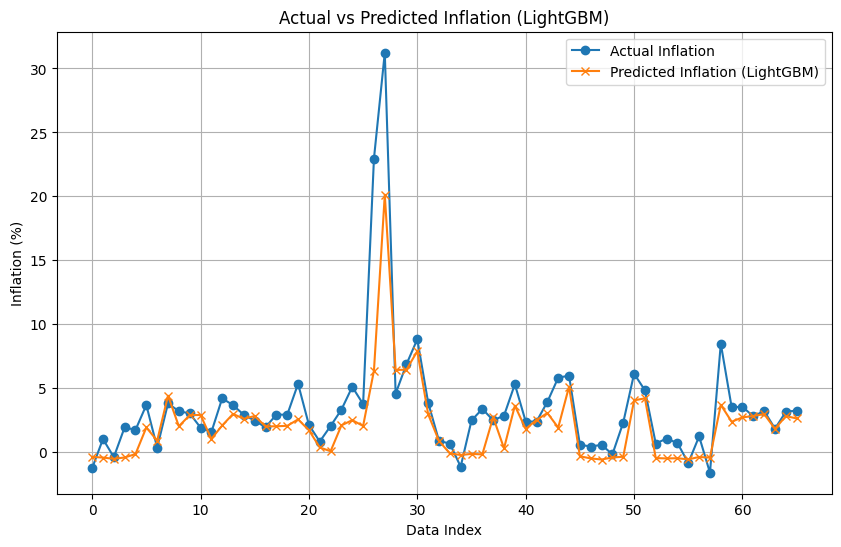

In [ ]:
# -------------------------------------------------------------
# 10. VISUALIZATION ACTUAL VS PREDICTION
# -------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Inflation', marker='o')
plt.plot(y_pred_lgb, label='Predicted Inflation (LightGBM)', marker='x')
plt.title('Actual vs Predicted Inflation (LightGBM)')
plt.xlabel('Data Index')
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -------------------------------------------------------------
# 11. PREDICTION RESULT (LightGBM)
# -------------------------------------------------------------
import numpy as np
import pandas as pd

future_years = [2024, 2025, 2026, 2027, 2028, 2029, 2030]

df_last = (
    df_clean.sort_values(['Country Code','Year'])
            .groupby('Country Code')
            .tail(3)
)

results = []

for country in df_last['Country Code'].unique():

    temp = df_last[df_last['Country Code'] == country].copy()

    lag1 = temp['Inflation'].iloc[-1]
    lag2 = temp['Inflation'].iloc[-2]
    lag3 = temp['Inflation'].iloc[-3]

    last_trend = temp['Trend'].iloc[-1]
    country_code_encoded = temp['Country_Code_Encoded'].iloc[0]

    for year in future_years:

        trend = last_trend + 1
        last_trend = trend

        rolling_mean3 = np.mean([lag1, lag2, lag3])
        rolling_std3  = np.std([lag1, lag2, lag3])

        X_future = pd.DataFrame([{
            'Year': year,
            'Trend': trend,
            'Inflation_lag1': lag1,
            'Inflation_lag2': lag2,
            'Inflation_lag3': lag3,
            'rolling_mean3': rolling_mean3,
            'rolling_std3':  rolling_std3,
            'Country_Code_Encoded': country_code_encoded
        }])

        pred = lgbm_model.predict(X_future)[0]

        results.append([country, year, pred])

        lag3 = lag2
        lag2 = lag1
        lag1 = pred

df_pred_lgb = pd.DataFrame(results, columns=['Country Code','Year','Predicted Inflation'])
df_pred_lgb

,Country Code,Year,Predicted Inflation
0,BRN,2024,1.129030
1,BRN,2025,0.246577
2,BRN,2026,-0.395125
3,BRN,2027,-0.131446
4,BRN,2028,-0.279704
...,...,...,...
65,VNM,2026,2.867322
66,VNM,2027,2.875986
67,VNM,2028,2.876751
68,VNM,2029,2.876751


Beberapa pendekatan pemodelan digunakan untuk membandingkan kemampuan model statistik dan machine learning dalam memprediksi CPI. Model-model ini kemudian digunakan sebagai dasar analisis perbandingan dan risiko inflasi, bukan sebagai tujuan akhir prediksi.

# Comparison Plot

## Linear Regression vs XGBoost

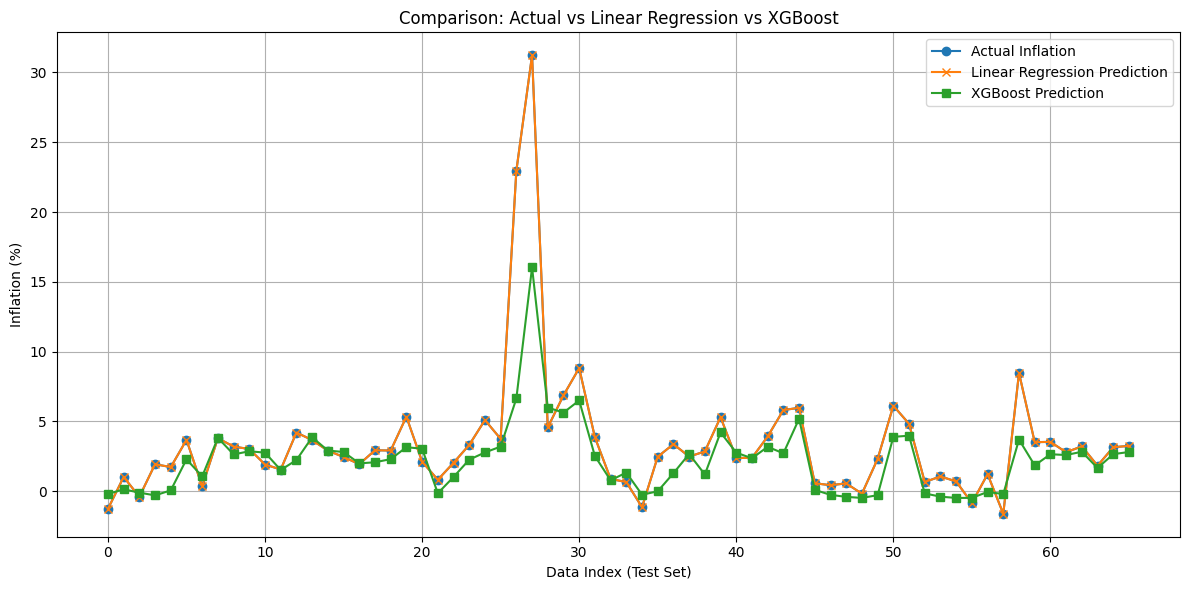

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------------------
# PREDICTIONS FROM BOTH MODELS
# -------------------------------------------
y_pred_lr  = model.predict(X_test)        # Linear Regression
y_pred_xgb = xgb_model.predict(X_test)    # XGBoost

# -------------------------------------------
# PLOTTING
# -------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual Inflation', marker='o')
plt.plot(y_pred_lr, label='Linear Regression Prediction', marker='x')
plt.plot(y_pred_xgb, label='XGBoost Prediction', marker='s')

plt.title('Comparison: Actual vs Linear Regression vs XGBoost')
plt.xlabel('Data Index (Test Set)')
plt.ylabel('Inflation (%)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest vs XGBoost

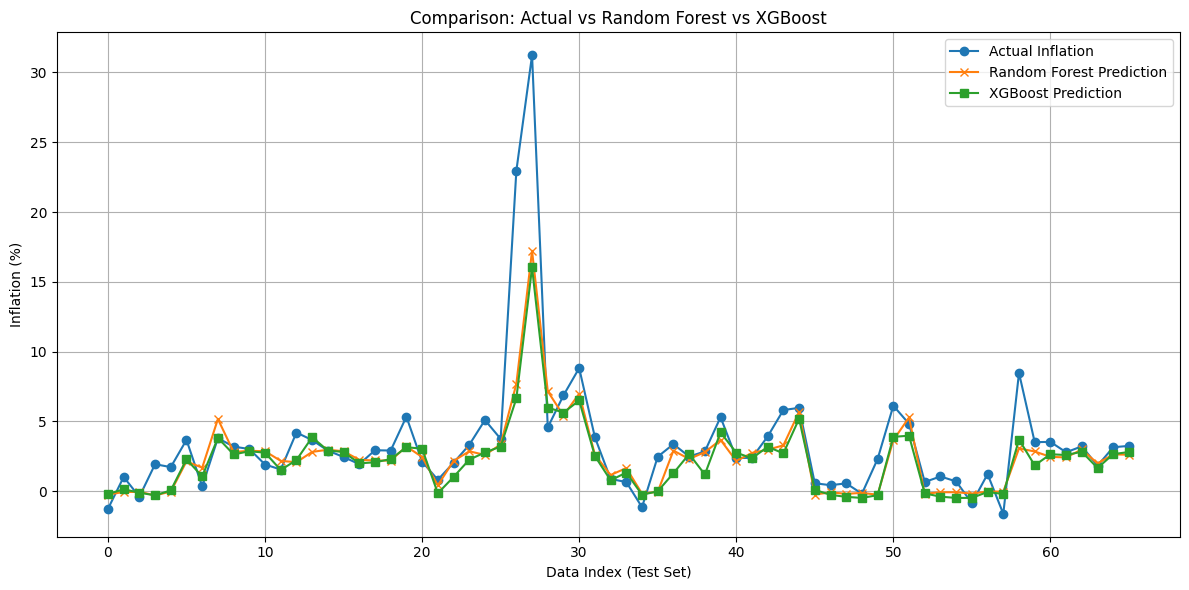

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------------------
# PREDICTIONS
# -------------------------------------------
y_pred_rf  = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# -------------------------------------------
# PLOT
# -------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual Inflation', marker='o')
plt.plot(y_pred_rf, label='Random Forest Prediction', marker='x')
plt.plot(y_pred_xgb, label='XGBoost Prediction', marker='s')

plt.title('Comparison: Actual vs Random Forest vs XGBoost')
plt.xlabel('Data Index (Test Set)')
plt.ylabel('Inflation (%)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## LGBM vs XGBoost

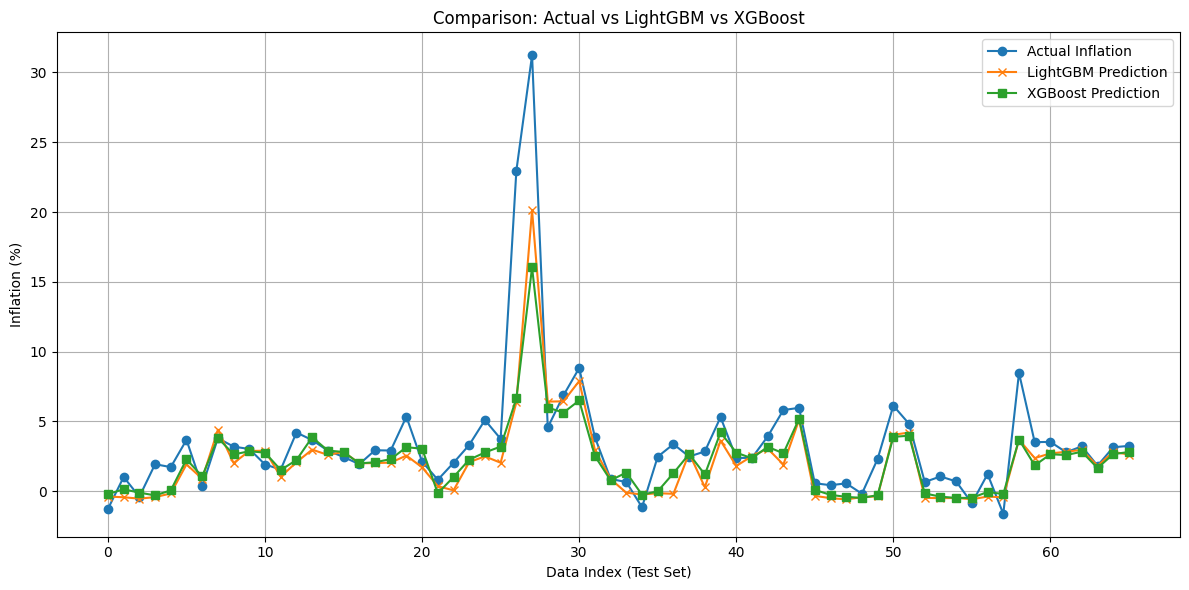

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------------------
# PREDICTIONS
# -------------------------------------------
y_pred_lgb = lgbm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# -------------------------------------------
# PLOT
# -------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual Inflation', marker='o')
plt.plot(y_pred_lgb, label='LightGBM Prediction', marker='x')
plt.plot(y_pred_xgb, label='XGBoost Prediction', marker='s')

plt.title('Comparison: Actual vs LightGBM vs XGBoost')
plt.xlabel('Data Index (Test Set)')
plt.ylabel('Inflation (%)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Random Forest vs LGBM

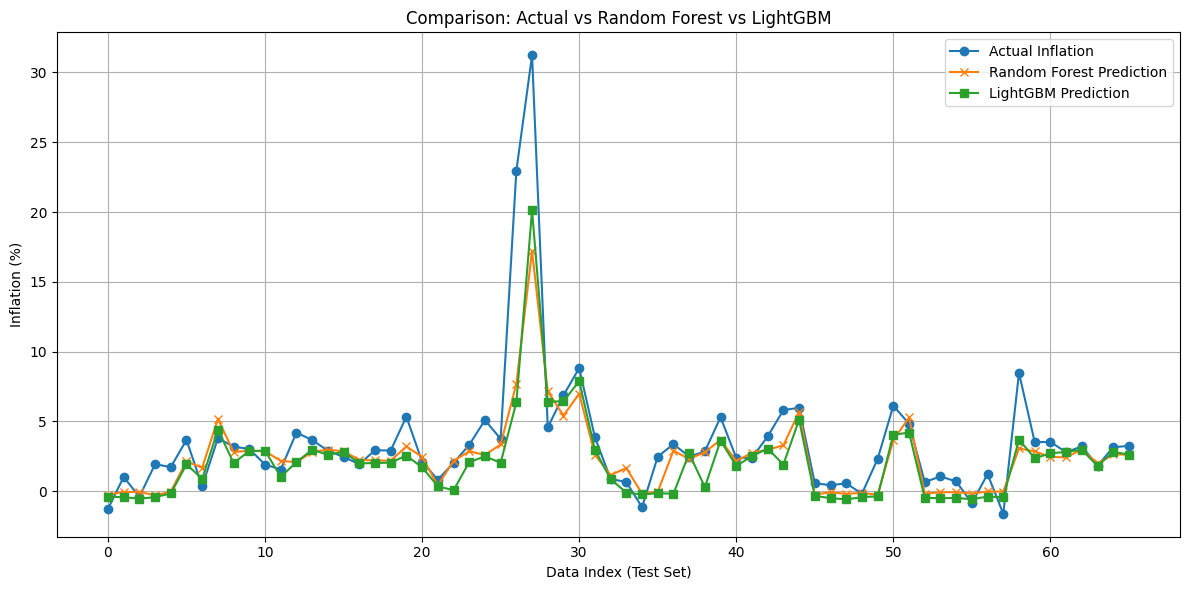

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------------------
# PREDICTIONS
# -------------------------------------------
y_pred_rf  = rf_model.predict(X_test)
y_pred_lgb = lgbm_model.predict(X_test)

# -------------------------------------------
# PLOT
# -------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(y_test.values, label='Actual Inflation', marker='o')
plt.plot(y_pred_rf, label='Random Forest Prediction', marker='x')
plt.plot(y_pred_lgb, label='LightGBM Prediction', marker='s')

plt.title('Comparison: Actual vs Random Forest vs LightGBM')
plt.xlabel('Data Index (Test Set)')
plt.ylabel('Inflation (%)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Sarima vs XGBoost (IDN)

Jujur bingung disini, kemungkinan saya skip sarima karena gabisa langsung jadi 1 hehe

In [ ]:
# subset XGBoost prediction for Indonesia
mask_idn = X_test['Country_Code_Encoded'] == X_test['Country_Code_Encoded'].unique()[0]

y_true_xgb = y_test[mask_idn]
y_pred_xgb_idn = y_pred_xgb[mask_idn]

mae_xgb  = mean_absolute_error(y_true_xgb, y_pred_xgb_idn)
rmse_xgb = np.sqrt(mean_squared_error(y_true_xgb, y_pred_xgb_idn))
r2_xgb   = r2_score(y_true_xgb, y_pred_xgb_idn)

print("XGBoost Evaluation (Indonesia)")
print("------------------------------")
print(f"MAE  : {mae_xgb:.3f}")
print(f"RMSE : {rmse_xgb:.3f}")
print(f"R²   : {r2_xgb:.3f}")

XGBoost Evaluation (Indonesia)
------------------------------
MAE  : 1.178
RMSE : 1.320
R²   : 0.241


In [ ]:
# Ambil baris test set untuk Indonesia
df_test_plot = X_test.copy()
df_test_plot['Actual'] = y_test.values
df_test_plot['Pred_XGB'] = y_pred_xgb

# Filter Indonesia
idn_code = df_clean[df_clean['Country Code']=='IDN']['Country_Code_Encoded'].iloc[0]
df_test_plot = df_test_plot[df_test_plot['Country_Code_Encoded'] == idn_code]

df_test_plot = df_test_plot.sort_values('Year')

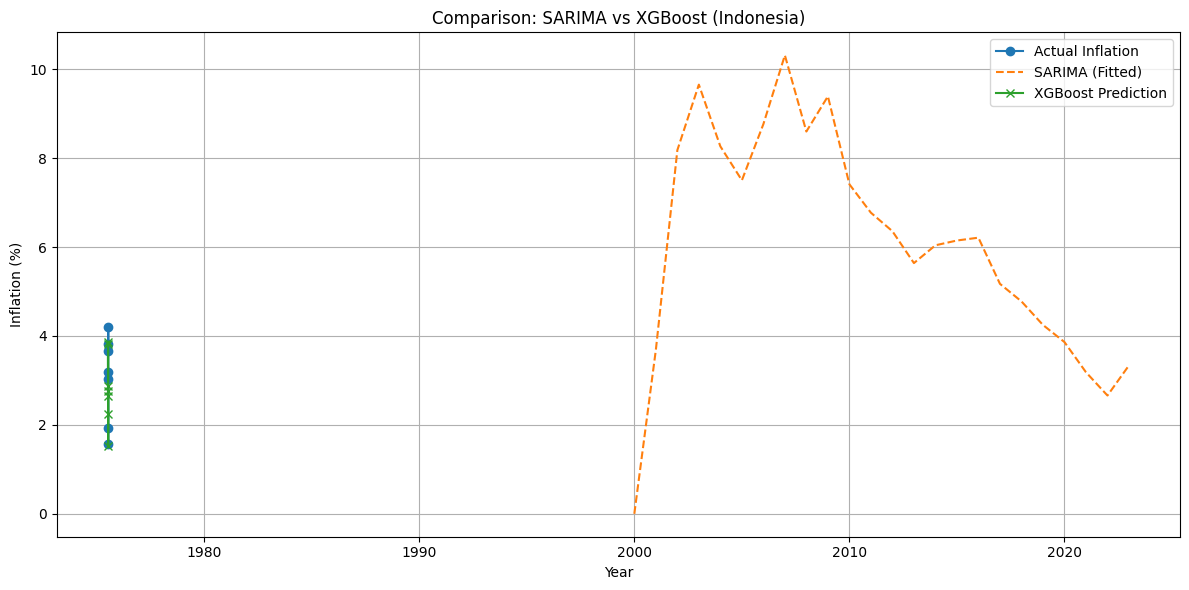

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Actual
plt.plot(
    df_test_plot['Year'],
    df_test_plot['Actual'],
    marker='o',
    label='Actual Inflation'
)

# SARIMA fitted
plt.plot(
    sarima_fitted.index.to_timestamp(),
    sarima_fitted.values,
    linestyle='--',
    label='SARIMA (Fitted)'
)

# XGBoost prediction
plt.plot(
    df_test_plot['Year'],
    df_test_plot['Pred_XGB'],
    marker='x',
    label='XGBoost Prediction'
)

plt.title('Comparison: SARIMA vs XGBoost (Indonesia)')
plt.xlabel('Year')
plt.ylabel('Inflation (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Visualisasi perbandingan menunjukkan adanya perbedaan dinamika inflasi antar negara ASEAN. Grafik ini memberikan gambaran awal mengenai stabilitas dan volatilitas inflasi sebelum dianalisis lebih lanjut secara kuantitatif melalui tabel perbandingan.

# Comparison Table

In [ ]:
df_rf = df_pred_rf.rename(
    columns={'Predicted Inflation': 'RF_Predicted'}
)

df_xgb = df_pred_xgb.rename(
    columns={'Predicted Inflation': 'XGB_Predicted'}
)

df_compare = pd.merge(
    df_rf,
    df_xgb,
    on=['Country Code', 'Year'],
    how='inner'
)

df_compare['Difference_RF_minus_XGB'] = (
    df_compare['RF_Predicted'] - df_compare['XGB_Predicted']
)

df_compare.sort_values(['Country Code','Year']).head(100)

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,BRN,2024,1.791359,1.428981,0.362377
1,BRN,2025,2.870553,2.177567,0.692986
2,BRN,2026,1.998868,-0.193167,2.192035
3,BRN,2027,2.060117,-0.268415,2.328532
4,BRN,2028,2.177437,-0.132025,2.309462
...,...,...,...,...,...
65,VNM,2026,2.734812,2.675128,0.059684
66,VNM,2027,2.266553,1.944551,0.322002
67,VNM,2028,2.151917,1.930185,0.221732
68,VNM,2029,2.038200,1.441939,0.596261


## BRN (Brunei Darussalam)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['BRN']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,BRN,2024,1.791359,1.428981,0.362377
1,BRN,2025,2.870553,2.177567,0.692986
2,BRN,2026,1.998868,-0.193167,2.192035
3,BRN,2027,2.060117,-0.268415,2.328532
4,BRN,2028,2.177437,-0.132025,2.309462
5,BRN,2029,2.027841,-0.186158,2.213999
6,BRN,2030,2.032121,-0.312069,2.344190


## IDN (Indonesia)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['IDN']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,IDN,2024,2.387742,2.295955,0.091787
1,IDN,2025,3.167151,3.187186,-0.020035
2,IDN,2026,2.946436,2.715332,0.231104
3,IDN,2027,2.887924,2.863665,0.024259
4,IDN,2028,3.233868,3.162419,0.071449
5,IDN,2029,2.971411,3.039888,-0.068478
6,IDN,2030,3.146322,2.942903,0.203418


## KHM (Kamboja)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['KHM']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,KHM,2024,2.810330,2.552109,0.258221
1,KHM,2025,3.317495,3.257607,0.059888
2,KHM,2026,2.578112,1.850697,0.727415
3,KHM,2027,2.990574,2.072415,0.918159
4,KHM,2028,3.109982,2.340110,0.769872
5,KHM,2029,2.856801,1.539605,1.317196
6,KHM,2030,3.209275,1.400367,1.808908


## LAO (Laos)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['LAO']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,LAO,2024,12.509577,8.010073,4.499504
1,LAO,2025,15.030588,10.347572,4.683016
2,LAO,2026,15.208528,8.895880,6.312648
3,LAO,2027,13.625317,6.025345,7.599972
4,LAO,2028,13.851394,6.159971,7.691423
5,LAO,2029,13.938653,6.751467,7.187186
6,LAO,2030,13.964797,5.354007,8.610790


## MMR (Myanmar)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['MMR']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,MMR,2024,2.890541,8.177104,-5.286563
1,MMR,2025,3.045920,10.033216,-6.987296
2,MMR,2026,3.054399,8.703998,-5.649599
3,MMR,2027,3.008315,6.046623,-3.038308
4,MMR,2028,3.107250,6.085525,-2.978275
5,MMR,2029,2.946576,6.983545,-4.036969
6,MMR,2030,3.105176,5.366568,-2.261392


## MYS (Malaysia)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['MYS']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,MYS,2024,2.743871,2.866318,-0.122446
1,MYS,2025,2.890487,3.134306,-0.243818
2,MYS,2026,2.605003,2.911178,-0.306175
3,MYS,2027,2.764674,3.049518,-0.284843
4,MYS,2028,2.764248,3.102794,-0.338545
5,MYS,2029,2.645954,2.952478,-0.306524
6,MYS,2030,2.777095,3.006455,-0.229360


## PHL (Philipina)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['PHL']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,PHL,2024,5.510389,4.472811,1.037578
1,PHL,2025,5.801270,5.096421,0.704849
2,PHL,2026,5.867669,5.060005,0.807664
3,PHL,2027,5.878327,4.722048,1.156279
4,PHL,2028,5.849680,5.211086,0.638594
5,PHL,2029,5.825264,5.042037,0.783227
6,PHL,2030,5.831693,5.199740,0.631953


## SGP (Singapura)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['SGP']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,SGP,2024,5.232964,3.535440,1.697524
1,SGP,2025,5.500391,4.286033,1.214358
2,SGP,2026,5.526274,3.064352,2.461923
3,SGP,2027,5.660546,2.420276,3.240270
4,SGP,2028,5.862937,2.934860,2.928077
5,SGP,2029,5.878775,2.700970,3.177806
6,SGP,2030,5.856241,2.211260,3.644981


## THA (Thailand)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['THA']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,THA,2024,3.147828,3.372722,-0.224894
1,THA,2025,2.023873,2.352071,-0.328198
2,THA,2026,5.395523,4.975341,0.420181
3,THA,2027,2.306614,2.936753,-0.630139
4,THA,2028,2.471562,2.398716,0.072846
5,THA,2029,3.075160,3.170218,-0.095059
6,THA,2030,1.943048,2.644261,-0.701213


## VNM (Vietnam)

In [ ]:
# dictionary untuk menyimpan tabel per negara
tables_by_country = {}

for country in df_compare['Country Code'].unique():
    tables_by_country[country] = (
        df_compare[df_compare['Country Code'] == country]
        .reset_index(drop=True)
    )

# contoh tampilkan Indonesia
tables_by_country['VNM']

,Country Code,Year,RF_Predicted,XGB_Predicted,Difference_RF_minus_XGB
0,VNM,2024,2.421159,2.298638,0.122521
1,VNM,2025,2.837587,2.789495,0.048092
2,VNM,2026,2.734812,2.675128,0.059684
3,VNM,2027,2.266553,1.944551,0.322002
4,VNM,2028,2.151917,1.930185,0.221732
5,VNM,2029,2.038200,1.441939,0.596261
6,VNM,2030,1.939970,0.935480,1.004490


Berdasarkan tabel perbandingan, Indonesia berada pada kategori volatilitas inflasi menengah dibandingkan negara ASEAN lainnya. Negara seperti Filipina dan Vietnam menunjukkan volatilitas yang lebih tinggi, sementara Malaysia dan Singapura relatif lebih stabil. Temuan ini menunjukkan bahwa inflasi Indonesia dipengaruhi dinamika regional, namun tidak berada pada kondisi ekstrem.

# Calculate volatility per country

In [ ]:
import pandas as pd
import numpy as np

volatility_table = (
    df_compare
    .groupby('Country Code')
    .agg(
        RF_Volatility=('RF_Predicted', 'std'),
        XGB_Volatility=('XGB_Predicted', 'std'),
        Mean_RF=('RF_Predicted', 'mean'),
        Mean_XGB=('XGB_Predicted', 'mean')
    )
    .reset_index()
)

# Volatilitas gabungan
volatility_table['Avg_Volatility'] = (
    volatility_table[['RF_Volatility', 'XGB_Volatility']]
    .mean(axis=1)
)

# Rata-rata inflasi
volatility_table['Avg_Inflation'] = (
    volatility_table[['Mean_RF', 'Mean_XGB']]
    .mean(axis=1)
)

volatility_table

,Country Code,RF_Volatility,XGB_Volatility,Mean_RF,Mean_XGB,Avg_Volatility,Avg_Inflation
0,BRN,0.343295,1.011535,2.136899,0.359245,0.677415,1.248072
1,IDN,0.284475,0.308711,2.962979,2.886764,0.296593,2.924872
2,KHM,0.254602,0.639605,2.981796,2.144701,0.447104,2.563249
3,LAO,0.904536,1.794562,14.018408,7.363473,1.349549,10.690941
4,MMR,0.080584,1.687337,3.022597,7.342369,0.883960,5.182483
5,MYS,0.093349,0.099198,2.741619,3.003292,0.096274,2.872456
6,PHL,0.128140,0.273503,5.794899,4.972022,0.200822,5.383460
7,SGP,0.242140,0.706307,5.645447,3.021884,0.474224,4.333666
8,THA,1.192908,0.901715,2.909087,3.121440,1.047311,3.015264
9,VNM,0.342033,0.660913,2.341457,2.002202,0.501473,2.171830


Nilai volatilitas digunakan untuk mengukur tingkat ketidakstabilan inflasi di masing-masing negara. Volatilitas yang lebih tinggi mengindikasikan risiko fluktuasi harga yang lebih besar, yang berpotensi berdampak pada stabilitas daya beli.

# Inflation risk classification
Rules:

High volatility → above the median

High inflation → above the median

In [ ]:
vol_median = volatility_table['Avg_Volatility'].median()
inf_median = volatility_table['Avg_Inflation'].median()

def classify_risk(row):
    if row['Avg_Volatility'] >= vol_median and row['Avg_Inflation'] >= inf_median:
        return 'High Risk'
    elif row['Avg_Volatility'] >= vol_median:
        return 'Medium Risk (Volatile)'
    elif row['Avg_Inflation'] >= inf_median:
        return 'Medium Risk (High Inflation)'
    else:
        return 'Low Risk'

volatility_table['Inflation_Risk'] = volatility_table.apply(classify_risk, axis=1)

volatility_table.sort_values(
    ['Inflation_Risk', 'Avg_Volatility'],
    ascending=[True, False]
)

,Country Code,RF_Volatility,XGB_Volatility,Mean_RF,Mean_XGB,Avg_Volatility,Avg_Inflation,Inflation_Risk
3,LAO,0.904536,1.794562,14.018408,7.363473,1.349549,10.690941,High Risk
8,THA,1.192908,0.901715,2.909087,3.121440,1.047311,3.015264,High Risk
4,MMR,0.080584,1.687337,3.022597,7.342369,0.883960,5.182483,High Risk
2,KHM,0.254602,0.639605,2.981796,2.144701,0.447104,2.563249,Low Risk
1,IDN,0.284475,0.308711,2.962979,2.886764,0.296593,2.924872,Low Risk
5,MYS,0.093349,0.099198,2.741619,3.003292,0.096274,2.872456,Low Risk
7,SGP,0.242140,0.706307,5.645447,3.021884,0.474224,4.333666,Medium Risk (High Inflation)
6,PHL,0.128140,0.273503,5.794899,4.972022,0.200822,5.383460,Medium Risk (High Inflation)
0,BRN,0.343295,1.011535,2.136899,0.359245,0.677415,1.248072,Medium Risk (Volatile)
9,VNM,0.342033,0.660913,2.341457,2.002202,0.501473,2.171830,Medium Risk (Volatile)


Klasifikasi risiko membagi negara ASEAN ke dalam kelompok risiko rendah, menengah, dan tinggi. Posisi Indonesia pada kategori risiko menengah menunjukkan perlunya sistem peringatan dini berbasis data regional untuk mengantisipasi tekanan inflasi dari negara dengan volatilitas tinggi.

# Summary

Analisis ini menunjukkan bahwa inflasi Indonesia berada pada posisi moderat dalam konteks ASEAN, dengan dinamika yang masih dipengaruhi kondisi regional. Pendekatan berbasis machine learning dan perbandingan lintas negara dapat dimanfaatkan sebagai sistem pendukung keputusan dalam perumusan kebijakan stabilisasi harga.